# 2020-04-20 WS5_1 Transfer Learning - Base Model

<div class="alert alert-block alert-info">
<b>This tutorial is based on:</b>
<ul><li>
<a href="https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb">Human Activity Recognition Tutorial with Keras and CoreML (Part 1)</a>
</li></ul>
</div>

We will train a generic deep neural network (DNN) to recognize the type of activity based on a given set of accelerometer data from a mobile device. We will use the WISDM data set for this tutorial (<a href="http://www.cis.fordham.edu/wisdm/dataset.php">WISDM</a>). The data set that we are using is a collection of accelerometer data taken from a smartphone that various people carried with them while conducting six different exercises (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking). For each exercise the acceleration for the x, y, and z axis was measured and captured with a timestamp and person ID.

With this available data, we would like to train a simple neural network in order to understand if a person carrying a smartphone is performing any of the six activities. Once the neural network has been trained on this existing data, it should be able to correctly predict the type of activity a person is conducting.

We use a deep neural network to solve the problem. Based on the available data it will learn how to differentiate between each of the six activities. We can then show new data to the neural network and it will tell us what the user is doing at any particular point in time.

First we need to import all necessary python libraries. If you are missing some of them, install them using the <code>pip</code> installer.

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

# Same labels will be reused throughout the program
LABELS = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

Using TensorFlow backend.


Next, you need to download the dataset form <a href="http://www.cis.fordham.edu/wisdm/dataset.php">here</a> and store it locally. The important file is <code>ws4_tl/WISDM_ar_v1.1_raw.txt</code>. We define a convenience function in order to read the data and show some basic information about the data.

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names, comment=';')
    df.dropna(axis=0, how='any', inplace=True)
    return df

# Load data set containing all the data from csv
df = read_data('ws4_tl/WISDM_ar_v1.1_raw.txt')

# Describe the data
print('Number of columns in the dataframe: %i' % (df.shape[1]))
print('Number of rows in the dataframe: %i\n' % (df.shape[0]))
df.head(5)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


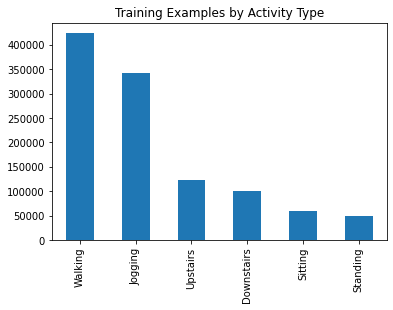

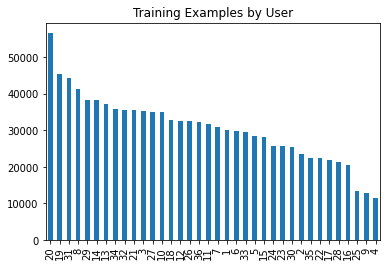

In [3]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different users
df['user-id'].value_counts().plot(kind='bar', title='Training Examples by User')
plt.show()

As we can see, we have more data for walking and jogging activities than we have for the other activities. Also we can see that 36 persons have participated in the experiment.
Next, let's take a look at the accelerometer data for each of the three axis for all six possible activities. The data is recorded at a sampling rate of 20 Hz (20 values per second). Since we show the first 180 records, each chart shows a 9 second interval for each of the six activities.

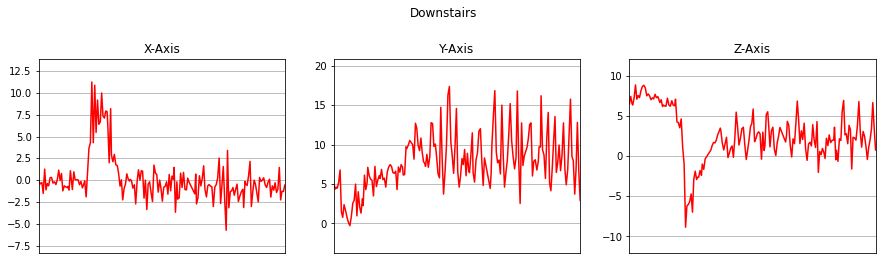

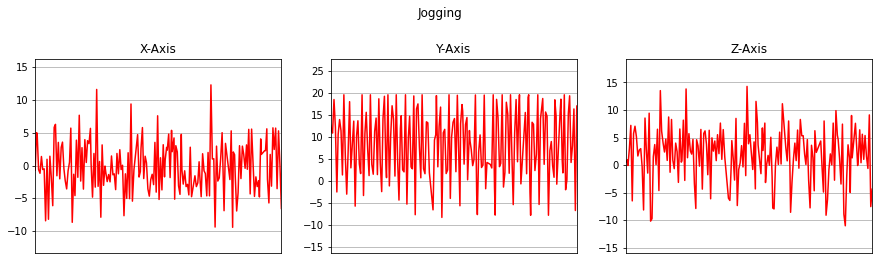

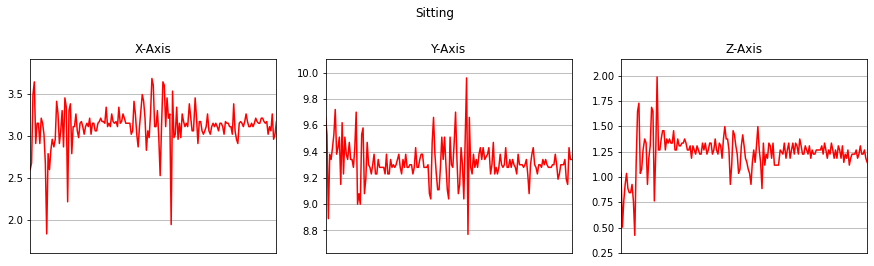

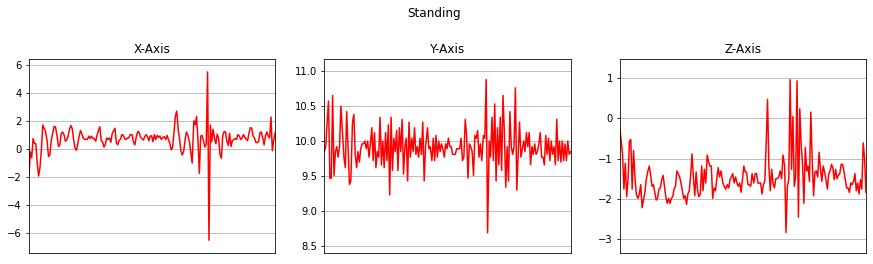

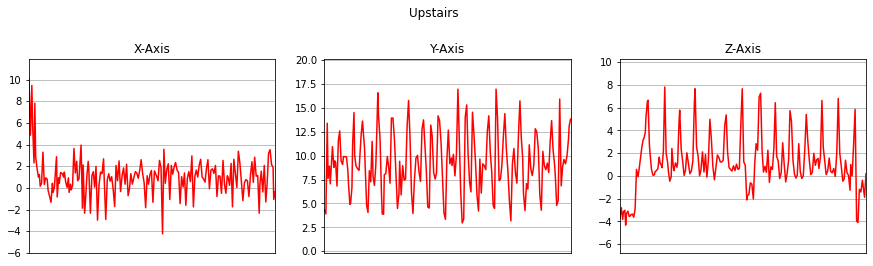

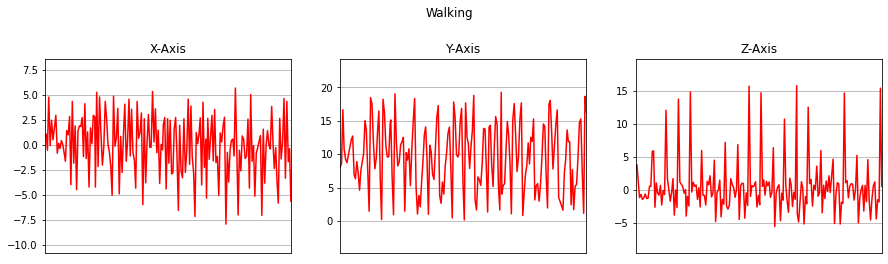

In [4]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,
         figsize=(15, 4),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.8)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

As expected, there is a higher acceleration for activities such as jogging and walking compared to sitting. Before we continue, we will add one more column with the name "ActivityEncoded" to the dataframe with the encoded value for each activity:

1. Downstairs
2. Jogging
3. Sitting
4. Standing
5. Upstairs
6. Walking

This is needed since the deep neural network cannot work with non-numerical labels. With the LabelEncoder, we are able to easily convert back to the original label text.

In [7]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

It is important to separate the whole data set into a training set and a test set. Often times, you see the beginner mistake on how the data is split. However you decide to split the data, you never want information from the test set to bleed into your training set. This might be great for the overall performance of your model during training and then validation against the test set. But your model is very unlikely to generalize well for data it has not seen yet.

The idea behind splitting: We want our neural network to learn from a few persons which have been through the experiment. Next, we then want to see how well our neural network predicts the movements of persons it has not seen before.

Only worrying about having at least a few example records per activity is not sufficient. You will run the risk that you have maybe three records of activity "Walking" for person 5 in the training set and one record for activity "Walking" for person 5 in the test set. Of course, with this type of situation, your model will perform great because it has already seen the movement pattern of person 5 during training. Please, always be critical about the performance of your DNN - it might be because of the wrong data split in the first place.

In our case, let's split based on the user IDs. We will keep users with ID 1 to 28 for training the model and users with ID greater than 28 for the test set. This also applies for any other sensor data (e.g. Internet of Things).

In [8]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization I also decided to round the three features to six digits. You can play around with the optimal number here in order to further increase the performance of your network.

In [9]:
# Normalize features for training data set (values between 0 and 1)
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let's create another function for this called <code>create_segments_and_labels</code>. This function will take in the dataframe and the label names (the constant that we have defined at the beginning) as well as the length of each record. In our case, let's go with 40 steps. Taking into consideration the 20 Hz sampling rate, this equals to 4 second time intervals (calculation: 0.05 * 80 = 4). Besides reshaping the data, the function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity).

In [10]:
def create_segments_and_labels(df, time_steps, step, label_name):
    N_FEATURES = 3 # x, y, z acceleration as features
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS,STEP_DISTANCE,LABEL)

By now, you should have both 20.868 records in x_train as well as in y_train. Each of the 20.868 records in x_train is a two dimensional matrix of the shape 80x3.

In [11]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


For constructing our deep neural network, we should now store the following dimensions:
* Number of time periods: This is the number of time periods within one record (since we wanted to have a 2 second time interval, this number is 40 in our case)
* Number of sensors: This is 3 since we only use the acceletion over the x, y, and z axis
* Number of classes: This is the amount of nodes for our output layer in the neural network. Since we want our neural network to predict the type of activity, we will take the number of classes from the encoder that we have used earlier.

In [12]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


The data that we would like to feed into our network is 2-dimensional (80x3). We flatten the data for our input layer into the neural network. Instead of feeding a matrix of shape 80x3 we will feed in a list of 240 values.

In [13]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20868, 240)
input_shape: 240


Before continuing, we need to convert all feature data (x_train) and label data (y_train) into a datatype accepted by Keras.

In [14]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

We are almost done with the preparation of our data. One last step we need to do is to conduct [one-hot-encoding](https://en.wikipedia.org/wiki/One-hot) of our labels. Please only execute this line once!

In [15]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


By now, you have completed all the heavy-lifting on your side. The data is ready in such a format that Keras will be able to process it. I have decided to create a neural network with 3 hidden layers of fully connected nodes each (feel free to play around with the shape of the network or even switch to more complex ones like a convolutional neural network).

In [16]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(32, activation='relu'))
model_m.add(Dense(16, activation='relu'))
model_m.add(Dense(8, activation='relu', name="headlayer"))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 80, 3)             0         
_________________________________________________________________
dense (Dense)                (None, 80, 32)            128       
_________________________________________________________________
dense_1 (Dense)              (None, 80, 16)            528       
_________________________________________________________________
headlayer (Dense)            (None, 80, 8)             136       
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3846      
Total params: 4,638
Trainable params: 4,638
Non-trainable params: 0
______________________________________________________

Next, we will fit / train the model with our training data that we have prepared earlier. We will define an early stopping callback monitor on training accuracy: if the training fails to improve for two consecutive epochs, then the training will stop with the best model. The hyperparameter used for the training are quite simple: We will use a batch size of 400 records and will train the model for 50 epochs. For model training, we will use a 80:20 split to separate training data and validation data. It is that simple. So let's go ahead and train our model. There are some good explanations out there on the different hyperparameters, for instance <a href="https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9">here</a>.

In [18]:
model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train, y_train_hot, batch_size=BATCH_SIZE, epochs=EPOCHS,
                      validation_split=0.2, verbose=1)

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 1s 51us/sample - loss: 0.3788 - accuracy: 0.8629 - val_loss: 0.6806 - val_accuracy: 0.7925
Epoch 2/50
16694/16694 [==============================] - 0s 21us/sample - loss: 0.3731 - accuracy: 0.8659 - val_loss: 0.6909 - val_accuracy: 0.7798
Epoch 3/50
16694/16694 [==============================] - 0s 22us/sample - loss: 0.3735 - accuracy: 0.8635 - val_loss: 0.7186 - val_accuracy: 0.7575
Epoch 4/50
16694/16694 [==============================] - 0s 21us/sample - loss: 0.3709 - accuracy: 0.8662 - val_loss: 0.6781 - val_accuracy: 0.7861
Epoch 5/50
16694/16694 [==============================] - 0s 22us/sample - loss: 0.3687 - accuracy: 0.8674 - val_loss: 0.7227 - val_accuracy: 0.7508
Epoch 6/50
16694/16694 [==============================] - 0s 21us/sample - loss: 0.3677 - accuracy: 0.8640 - val_loss: 0.7092 - val_accuracy: 0.7700
Epoch 7/50
16694/16694 [==============================] -

The performance of this simple DNN is OK. We have validation accuracy of approximately 73%. This could definitely be improved - maybe with further hyperparameter tuning and especially with a modified neural network design. Before we go on with the test validation, we will print the learning curve for both the training and validation data set.

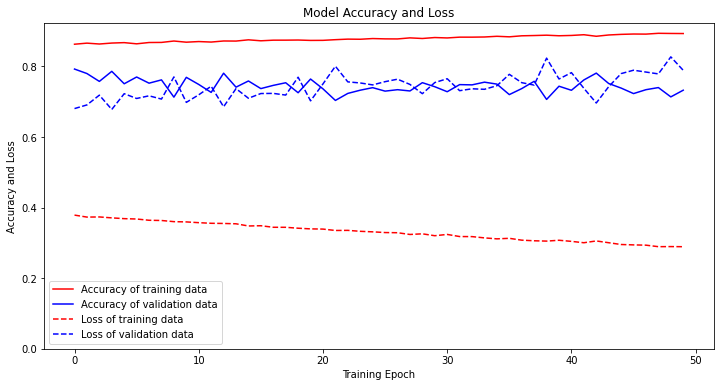

              precision    recall  f1-score   support

         0.0       0.55      0.51      0.53      1864
         1.0       0.97      0.98      0.97      6567
         2.0       0.99      0.99      0.99      1050
         3.0       0.99      0.99      0.99       833
         4.0       0.63      0.59      0.61      2342
         5.0       0.87      0.90      0.89      8212

    accuracy                           0.86     20868
   macro avg       0.83      0.83      0.83     20868
weighted avg       0.86      0.86      0.86     20868



In [19]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

Let's continue with this model and see how it performs against the test data that we have held back earlier. In our case, we will check the performance against the movements of the six users that the model has not yet seen.

In [20]:
# Normalize features for training data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=0)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])


Accuracy on test data: 0.76

Loss on test data: 1.17


The accuracy on the test data is 76%. This means that our model generalizes well for persons it has not yet seen. Let's see where our model wrongly predicted the labels.

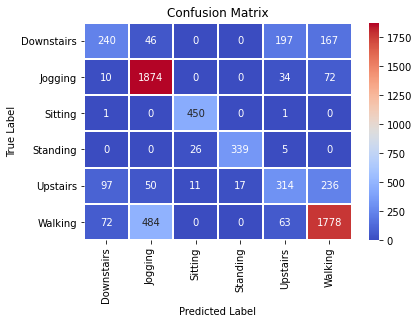

              precision    recall  f1-score   support

           0       0.57      0.37      0.45       650
           1       0.76      0.94      0.84      1990
           2       0.92      1.00      0.96       452
           3       0.95      0.92      0.93       370
           4       0.51      0.43      0.47       725
           5       0.79      0.74      0.76      2397

    accuracy                           0.76      6584
   macro avg       0.75      0.73      0.74      6584
weighted avg       0.75      0.76      0.75      6584



In [21]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

As you can see, the precision of the model is good for predicting jogging (1), sitting (2), standing (3), and walking (5). The model has problems for clearly identifying upstairs and downstairs activities.
There is of course still great potential for improving the model, but for our purpose of having a "generic" model the result is good enough. We further store the model and convert it into the TFLite format.

In [25]:
# Save the model
model_m.save('ws4_tl/saved_model.pbtxt')

In [26]:
# Convert the model with TFLite
import tensorflow

converter = tensorflow.lite.TFLiteConverter.from_keras_model(model_m)
tflite_model = converter.convert()
open("ws4_tl/converted_model.tflite", "wb").write(tflite_model)

21676